In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import coint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.model_selection import train_test_split

from numpy.random import uniform, randint, choice
from scipy.stats import norm

In [32]:
def mpAvgActiveSignals(signals, tPnts):
    out=pd.Series()
    
    for loc in tPnts:
        df0=(signals.index.values<=loc)&((loc<signals['t1'])|pd.isnull(signals['t1']))
    
        act=signals[df0].index
        
        if len(act)>0:
            out[loc]=signals.loc[act,'signal'].mean()
        else:
            out[loc]=0 # no signals active at this time
    return out

def avgActiveSignals(signals):

    # create list of every date that is a start or end point for a signal
    tPnts=set(signals['t1'].dropna().values)
    tPnts=tPnts.union(signals.index.values)
    
    tPnts=list(tPnts)
    
    tPnts.sort()
    out = mpAvgActiveSignals(signals, tPnts)
    
    return out

def discreteSignal(signal0,stepSize):
    # discretize signal
    signal1=(signal0/stepSize).round()*stepSize # discretize
    signal1[signal1>1]=1 # cap
    signal1[signal1<-1]=-1 # floor
    return signal1

# Exercises

### 10.2

Draw 10,000 random numbers from a uniform distribution with bounds U[.5, 1.].
(a) Compute the bet sizes m for ‖X‖ = 2.

(b) Assign 10,000 consecutive calendar days to the bet sizes.

(c) Draw 10,000 random numbers from a uniform distribution with bounds U [1, 25].

(d) Form a pandas series indexed by the dates in 2.b, and with values equal to the index shifted forward the number of days in 2.c. This is a t1 object
similar to the ones we used in Chapter 3.

(e) Compute the resulting average active bets, following Section 10.4.

In [39]:
def form_bet_size(p, sign, num_classes):
    z_statistic = (p - 1/num_classes) / np.sqrt(p*(1 - p))
    Z = norm.cdf(z_statistic)
    return sign*(2*Z - 1)
    
# gives set of probabilities that we make bets based off. 
probs = uniform(0.5, 1, 10_000)
sign = choice([-1, 1], size=10_000) 

bet_sizes = form_bet_size(p=probs, sign=sign, num_classes=2)

date_range = pd.date_range(start=pd.Timestamp.today().normalize(), periods=10_000, freq='D')
bet_size_frame = pd.DataFrame({
    "probability": probs,
    "signal": bet_sizes
}, index=date_range)

day_shifts = randint(1, 25, 10_000)

# date when a position expires, i.e. label date
t1 = pd.DataFrame({
    "t1": date_range + pd.to_timedelta(day_shifts, unit='d')
}, index=date_range)

bet_size_frame["t1"] = t1

In [40]:
# for all event date - label dates intervals in bet_size_frame.index, average the active signals (bet sizes)
# active during that interval
averaged_bet_sizes = avgActiveSignals(bet_size_frame)

Text(0.5, 0, 'Date')

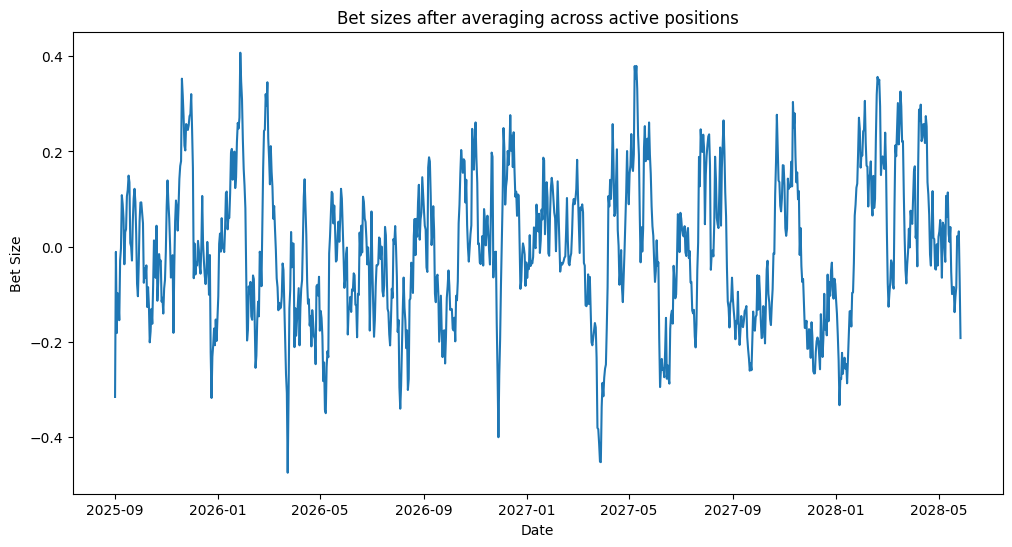

In [41]:
# Lots of overtrading, even after averaging bet sizes across active positions
plt.figure(figsize=(12, 6))
plt.plot(averaged_bet_sizes[:1000])
plt.title("Bet sizes after averaging across active positions")
plt.ylabel("Bet Size")
plt.xlabel("Date")

### 10.5

Repeat exercise 1, where you discretize m with a stepSize=.01,
stepSize=.05, and stepSize=.1.

Text(0.5, 0, 'Date')

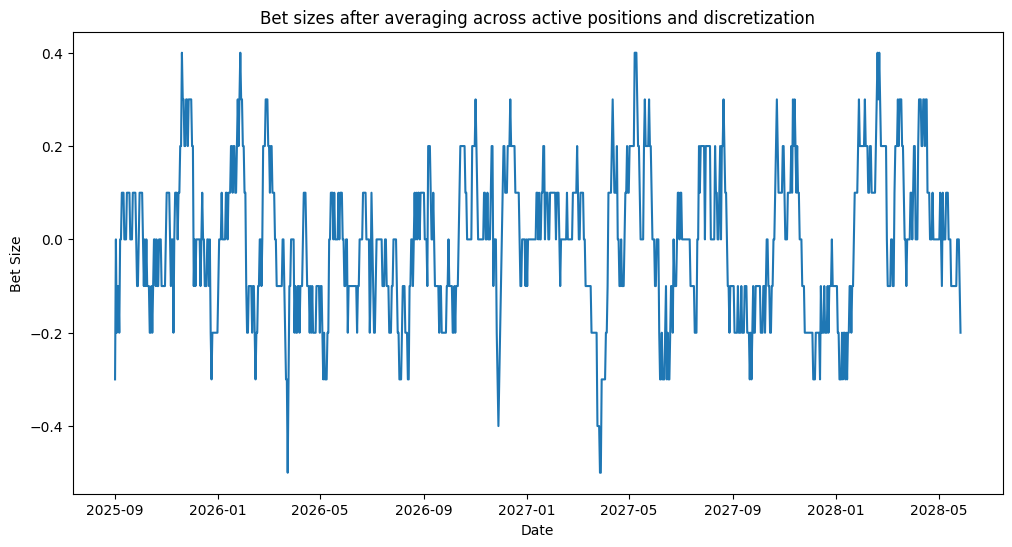

In [48]:
# Now we add bet size discretization in order to prevent inefficiencies from over trading. 
stepSize=0.01
discrete_averaged_bet_sizes = discreteSignal(averaged_bet_sizes, 0.1)

plt.figure(figsize=(12, 6))
plt.plot(discrete_averaged_bet_sizes[:1000])
plt.title("Bet sizes after averaging across active positions and discretization")
plt.ylabel("Bet Size")
plt.xlabel("Date")